In [33]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from recombinator.iid_bootstrap import iid_bootstrap
import recombinator.block_bootstrap as bb
from recombinator.optimal_block_length import optimal_block_length
from numba import njit
import yfinance as yf

import config

sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.3)

In [2]:
# Only care about march data for rpi so yr on yr

url = 'https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/czbh/mm23/data'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
# https://stackoverflow.com/questions/43590153/http-error-403-forbidden-when-reading-html
data = json.loads(r.text)
rpi_yronyr_df = pd.json_normalize(data, record_path=['months'])
#https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8
rpi_yronyr_df = rpi_yronyr_df[['date', 'value']].apply(pd.Series)
rpi_yronyr_df['value'] = rpi_yronyr_df['value'].astype(float)
rpi_yronyr_df['value'] = 1 + rpi_yronyr_df['value'] / 100

rpi_yronyr_df['date'] = pd.to_datetime(rpi_yronyr_df['date'], format='%Y %b')
rpi_yronyr_df = rpi_yronyr_df.set_index(['date'])

# rpi_yronyr_df = rpi_yronyr_df[] # only keep march data
rpi_yronyr_df.columns = ['rpi_yronyr']

is_march = (rpi_yronyr_df.index.month == 3)
j = -1
to_drop = []
for i in range(rpi_yronyr_df.shape[0]):
  if is_march[i]:
    j = i
  elif j == -1:
    to_drop.append(i)
  else:
    rpi_yronyr_df.iloc[i] = rpi_yronyr_df.iloc[j].values
        
rpi_yronyr_df.drop(index = rpi_yronyr_df.index[to_drop], inplace=True)

rpi_yronyr_df

,rpi_yronyr
date,
1949-03-01,1.023
1949-04-01,1.023
1949-05-01,1.023
1949-06-01,1.023
1949-07-01,1.023
...,...
2021-07-01,1.015
2021-08-01,1.015
2021-09-01,1.015


In [3]:
url = 'https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l59c/mm23/data'

r = requests.get(url, headers=header)
# https://stackoverflow.com/questions/43590153/http-error-403-forbidden-when-reading-html
data = json.loads(r.text)
cpih_mnthonmnth_df = pd.json_normalize(data, record_path=['months'])
# https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8
cpih_mnthonmnth_df = cpih_mnthonmnth_df[['date', 'value']].apply(pd.Series)
cpih_mnthonmnth_df['value'] = cpih_mnthonmnth_df['value'].astype(float)
cpih_mnthonmnth_df['value'] = 1 + cpih_mnthonmnth_df['value'] / 100

# https://stackoverflow.com/questions/65612231/convert-string-month-year-to-datetime-in-pandas-dataframe

cpih_mnthonmnth_df['date'] = pd.to_datetime(
    cpih_mnthonmnth_df['date'], format='%Y %b')
cpih_mnthonmnth_df = cpih_mnthonmnth_df.set_index(['date'])

cpih_mnthonmnth_df.columns = ['cpih_mnthonmnth']

cpih_mnthonmnth_df

,cpih_mnthonmnth
date,
1988-02-01,1.003
1988-03-01,1.004
1988-04-01,1.013
1988-05-01,1.005
1988-06-01,1.003
...,...
2021-07-01,1.000
2021-08-01,1.006
2021-09-01,1.003


In [5]:
SP500TR = yf.Ticker("^SP500TR").history(period = "max", interval="1mo")['Close'].to_frame()
# exchange = yf.Ticker("GBP=X").history(period = "max", interval="1d")['Close'].to_frame() # only goes to 2003

# Only since 2014 for USD to GBP though 2002 for GBP to USD

# from alpha_vantage.foreignexchange import ForeignExchange

# ALPHA_VANTAGE_API_KEY = config.alphaKey

# # Initialize the TimeSeries class with key and output format 
# fe = ForeignExchange(key=ALPHA_VANTAGE_API_KEY, output_format='pandas') 

# exchange, _ = fe.get_currency_exchange_daily(from_symbol='USD', to_symbol='GBP', outputsize='full') 

# # Rename column
# exchange = exchange['4. close'].to_frame()
# exchange.columns = ['Close']

# # Sort dates in ascending order
# exchange = exchange.sort_index(axis=0,ascending=True)

from fredapi import Fred

fred = Fred(api_key=config.fredKey)
exchange = fred.get_series('EXUSUK').to_frame()
exchange.columns = ['Close']
exchange.dropna()
exchange['Close'] = 1/exchange['Close'] 

SP500TR_month_gbp = SP500TR * exchange

SP500TR_month_gbp = SP500TR_month_gbp.dropna()

SP500TR_month_gbp

,Close
1988-02-01,153.270396
1988-03-01,142.471355
1988-04-01,140.581412
1988-05-01,142.455206
1988-06-01,156.764976
...,...
2021-08-01,6837.413987
2021-09-01,6550.269501
2021-10-01,7025.048924
2021-11-01,7099.702947


In [6]:
SP500TR_month_gbp_pct = SP500TR_month_gbp.pct_change()[1:]
SP500TR_month_gbp_pct['Close'] = SP500TR_month_gbp_pct['Close'] + 1
SP500TR_month_gbp_pct.columns = ['SP500TR_month_gbp_pct']
SP500TR_month_gbp_pct = SP500TR_month_gbp_pct.dropna()

all_data = SP500TR_month_gbp_pct.merge(
    cpih_mnthonmnth_df, left_index=True, right_index=True)

all_data = all_data.merge(
    rpi_yronyr_df, left_index=True, right_index=True)

all_data

,SP500TR_month_gbp_pct,cpih_mnthonmnth,rpi_yronyr
1988-03-01,0.929543,1.004,1.035
1988-04-01,0.986735,1.013,1.035
1988-05-01,1.013329,1.005,1.035
1988-06-01,1.100451,1.003,1.035
1988-07-01,1.038122,1.000,1.035
...,...,...,...
2021-07-01,1.039843,1.000,1.015
2021-08-01,1.031227,1.006,1.015
2021-09-01,0.958004,1.003,1.015
2021-10-01,1.072482,1.009,1.015


In [7]:
# Test with previous data which started on 2010-11-01, sp500 data seems quite different?

# all_data = all_data[all_data.index >= '2010-11-01']
# all_data

In [8]:
@njit()
def monthly_repayment(monthly_income, lower_taxband_monthly_income):
    delta_income = monthly_income - lower_taxband_monthly_income
    if delta_income > 0:
        return delta_income * 0.09
    else:
        return 0

@njit()
def working_interest(monthly_income, lower_taxband_monthly_income, upper_taxband_monthly_income, rpi):
    income = monthly_income
    bottom_band = lower_taxband_monthly_income
    upper_band = upper_taxband_monthly_income

    delta_income = income - bottom_band
    if delta_income > 0:
        if income > upper_band:
            # daily interest rate from annual interest rate
            return (rpi + 0.03) ** (1 / 365)
        else:
            # linear interpolation with 0% at 27295 and 3% at 49130
            return (rpi + delta_income / (upper_band - bottom_band) * 0.03) ** (1 / 365)
    else:
        return 1

In [9]:
# https://www.reddit.com/r/badeconomics/comments/k9g348/what_vanguard_wont_tell_you/
def gen_bootstrap_samples(returns_df, bootstrap_replications, no_of_months, kind, block_length=10):
    # Generate bootstrap samples

    if kind == "iid":
        bootstrap_samples = iid_bootstrap(
            np.array(returns_df),
            replications=bootstrap_replications,
            sub_sample_length=no_of_months,
        )
    elif kind == "stationary":
        bootstrap_samples = bb.stationary_bootstrap(
            np.array(returns_df),
            block_length=block_length,
            replications=bootstrap_replications,
            sub_sample_length=no_of_months,
        )
    else:
        raise Exception(f'Unknown bootstrap type: {kind}')

    return bootstrap_samples

In [10]:
@njit()
def sim_portfolio(bootstrap_sample, lower_taxband, upper_taxband, base_yrly_salary, real_salary_yronyr_growth, real_avg_salary_yronyr_growth, daterange1, daterange2):
    payments = 0
    npv_payments = 0
    npv_SP500_payments = 0

    i = 0  # which month bootstrap we are on
    # nominal_salary_index = 1
    # nominal_avg_salary_index = 1

    # only used for NPV calculation, starts when loan is first paid out unlike the previous indices which start on first job
    cpih_index = 1
    sp500_index = 1

    # income, adjusted on jan 01
    monthly_income = base_yrly_salary / 12
    lower_taxband_monthly_income = lower_taxband / 12
    upper_taxband_monthly_income = upper_taxband / 12

    # Whilst in University
    debt = 0

    for single_date in daterange1:
        if single_date in ("2021-10-20", "2022-02-02", "2022-10-19", "2023-02-01", "2023-10-18", "2024-01-31", "2024-10-17", "2025-01-30"):
            debt += .25 * 9250
        if single_date in ("2022-05-04", "2023-05-03", "2024-05-02", "2025-05-01"):
            debt += .5 * 9250

        if single_date in ("2021-10-05", "2022-01-18", "2022-04-26", "2022-10-04", "2023-01-17", "2023-04-25", "2023-10-03", "2024-01-16", "2024-04-24", "2024-10-02", "2025-01-15", "2025-04-23"): #change first_payment if this is changed
            debt += 4422/3
        
        interest = (bootstrap_sample[i, 2] + 0.03) ** (1 / 365) # bootstrap_sample[i, 2] is rpi from previous march
        debt = debt * interest

        if single_date[-2:] == '01':
            cpih_index *= bootstrap_sample[i, 1]
            sp500_index *= bootstrap_sample[i, 0]
            i += 1

    # After leaving University
    for single_date in daterange2:
        if single_date[-2:] == '01': 
            cpih_index *= bootstrap_sample[i, 1]
            sp500_index *= bootstrap_sample[i, 0]
        
            if single_date[-5:-3] == '01': # if first of jan give pay raise
                # nominal_salary_index *= real_salary_yronyr_growth * bootstrap_sample[i, 1]
                # nominal_avg_salary_index *= real_avg_salary_yronyr_growth * bootstrap_sample[i, 1]
                # # Real = Nominal / Price
                # # Nominal (t + 1) = Real (t + 1) * Price (t + 1)
                # # real_salary_yronyr_growth = Real(t + 1) / Real (t). Real(t + 1) - Real (t) / Real(t) =  Real(t + 1) / Real(t) - 1
                # # Nominal (t + 1) = Nominal(t) * Real(t + 1) / Real (t) * Price(t + 1) / Price (t)

                # # I can't remember whats going on above
                # # Nominal (t + 1) / Nominal (t) = Real (t + 1) * Price (t + 1) / (Real (t) * Price (t))

                monthly_income *= real_salary_yronyr_growth * bootstrap_sample[i, 1]
                lower_taxband_monthly_income *= real_avg_salary_yronyr_growth * bootstrap_sample[i, 1]
                upper_taxband_monthly_income *= real_avg_salary_yronyr_growth * bootstrap_sample[i, 1]

            repayment = monthly_repayment(monthly_income, lower_taxband_monthly_income)
            i += 1
        else:
            repayment = 0

        # interest is accrued daily whilst repayments are monthly so can't be inside previous if
        interest = working_interest(monthly_income, lower_taxband_monthly_income, upper_taxband_monthly_income, bootstrap_sample[i, 2])

        # if repayment > debt * interest
        repayment = min(repayment, debt * interest)
        debt = debt * interest - repayment # i.e. debt = 0

        payments += repayment

        npv_payments += repayment / cpih_index
        npv_SP500_payments += repayment / sp500_index

        if debt <= 0:
            # print(single_date)
            break

    #print("payments: %s, NPV: %s, NPV SP500: %s" %(payments, npv_payments, npv_SP500_payments))
    #print(".", end = '')
    return [payments, npv_payments, npv_SP500_payments]


In [11]:
from numba import prange

@njit(parallel=True)
def run_simulation_numba(bootstrap_samples, lower_taxband, upper_taxband, base_yrly_salary, real_salary_yronyr_growth, real_avg_salary_yronyr_growth, daterange1, daterange2):
    results = np.zeros((bootstrap_samples.shape[0], 3))

    for i in prange(bootstrap_samples.shape[0]):
        results[i] = sim_portfolio(bootstrap_samples[i], lower_taxband, upper_taxband, base_yrly_salary, real_salary_yronyr_growth, real_avg_salary_yronyr_growth, daterange1, daterange2)

    return results

In [12]:
"""
base_yrly_salary:                           the yearly salary in the first year    
real_salary_yronyr_growth_relative_to_avg:  Real wage growth compared to UK avergae   
"""
base_yrly_salary = 36000
real_salary_yronyr_growth_relative_to_avg = 0.02 # should change so its relative to avg for uni graduates

In [13]:
# Median income data is only available yearly till 1997 from Annual Survey of Hours and Earnings (ASHE), https://www.nomisweb.co.uk/datasets/asher? Average goes much further https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/timeseries/eqjp/emp but cba to work with it.
# this has from 2007 https://explore-education-statistics.service.gov.uk/find-statistics/graduate-labour-markets by education

real_avg_salary_yronyr_growth = 1.01
real_salary_yronyr_growth = real_avg_salary_yronyr_growth + real_salary_yronyr_growth_relative_to_avg

# real_salary_yronyr_growth = real_salary_yronyr_growth
# real_avg_salary_yronyr_growth = real_avg_salary_yronyr_growth

lower_taxband = 27295
upper_taxband = 49130

# Day of first payment from student loan company to me, also day interest starts accruing
first_payment = "2021-10-05"
# check the end date !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# dates when I start paying back loan
first_repayment = "2026-04-05"
last_repayment = (pd.Timestamp("2026-04-05") + pd.DateOffset(years = 30)).strftime("%Y-%m-%d") # 30 years after first repayment

daterange1 = [d.strftime("%Y-%m-%d")
              for d in pd.date_range(first_payment, first_repayment)]
daterange2 = [d.strftime("%Y-%m-%d")
              for d in pd.date_range((pd.Timestamp(first_repayment) + pd.DateOffset(1)).strftime("%Y-%m-%d"), last_repayment)]

from numba.typed import List
daterange1_numba = List(daterange1) # numba doens't like list of strings being passed to it, doubles in speed by this
daterange2_numba = List(daterange2)

In [14]:
start_date = pd.Timestamp(first_payment)
end_date = pd.Timestamp(last_repayment)
no_of_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

print('Generating bootstrap sample...')
bootstrap_samples = gen_bootstrap_samples(all_data, 100000, no_of_months, kind='stationary', block_length=36)
# block length was 10 years in example, however that is almost all of the data
# The block size is unfortunately a tuning parameter. The optimal stationary bootstrap block size for stocks and bonds was low, but it was over 10 years for cash-equivalent securities and inflation. Since the 'optimal' choice is calculated based on time-series dependence, I expect that there's more time dependence for cash and inflation. This could be related to the business cycle or 'regime-switching' behavior documented in the macro-econometrics lit (generally linked with monetary policy regimes). Anyways, knowing the optimal blocks size is hard, but I don't think it's too big of an issue to use 10yrs when the optimal length is more than 10 for some variables. Also, if the data really was independent, block bootstraps would work (should get results similar to iid bootstrap) but they would just be less efficient.

Generating bootstrap sample...


In [15]:
print('Simulating...')
results = run_simulation_numba(bootstrap_samples, lower_taxband, upper_taxband, base_yrly_salary, real_salary_yronyr_growth, real_avg_salary_yronyr_growth, daterange1_numba, daterange2_numba) # first run will take longer as numba has to compile btw

Simulating...


Plot...


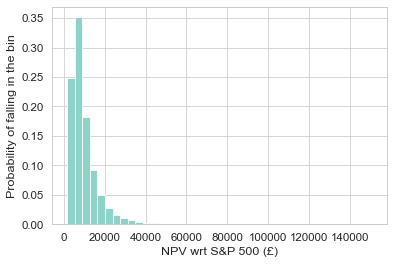

In [43]:
print('Plot...')

S = results[:, 2]
plt.hist(S, weights=np.ones_like(S) / len(S), bins=40)
plt.ylabel("Probability of falling in the bin")
plt.xlabel("NPV wrt S&P 500 (£)")
plt.show() # not necessary, used to hide output of previous command

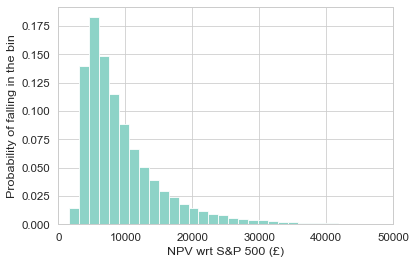

In [35]:
S = results[:, 2]
plt.hist(S, weights=np.ones_like(S) / len(S), bins=100)
plt.ylabel("Probability of falling in the bin")
plt.xlabel("NPV wrt S&P 500 (£)")
plt.xlim([0, 50000])
plt.show()

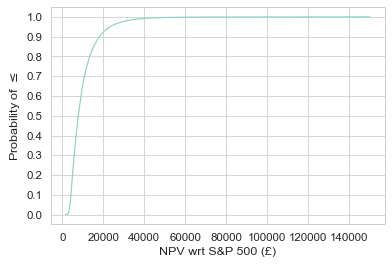

In [36]:
import matplotlib.ticker as ticker

S = results[:, 2]

fig, ax = plt.subplots(1,1)
ax.plot(np.sort(S), np.linspace(1/len(S), 1, len(S)))
plt.ylabel("Probability of $\leq$")
plt.xlabel("NPV wrt S&P 500 (£)")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show() # hides some output

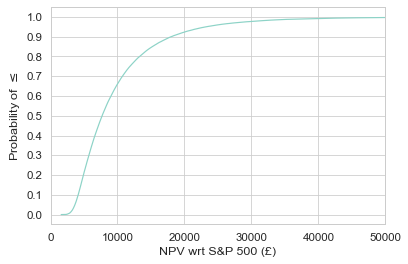

In [37]:
S = results[:, 2]

fig, ax = plt.subplots(1,1)
ax.plot(np.sort(S), np.linspace(1/len(S), 1, len(S)))
plt.ylabel("Probability of $\leq$")
plt.xlabel("NPV wrt S&P 500 (£)")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xlim([0, 50000])
plt.show()

Plot...


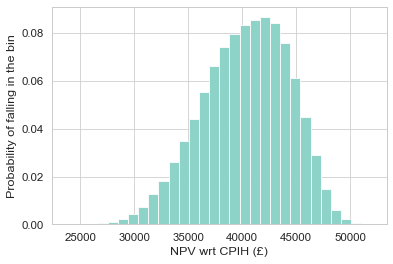

In [38]:
print('Plot...')
#plt.hist(results[:, 2])
S = results[:, 1]
plt.hist(S, weights=np.ones_like(S) / len(S), bins=30)
plt.ylabel("Probability of falling in the bin")
plt.xlabel("NPV wrt CPIH (£)")
plt.show() # not necessary, used to hide output of previous command

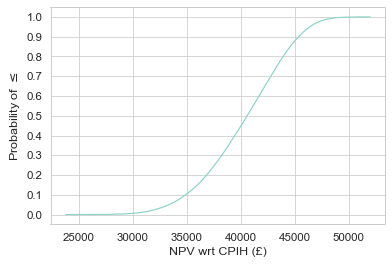

In [39]:
import matplotlib.ticker as ticker

S = results[:, 1]

fig, ax = plt.subplots(1,1)
ax.plot(np.sort(S), np.linspace(1/len(S), 1, len(S)))
plt.ylabel("Probability of $\leq$")
plt.xlabel("NPV wrt CPIH (£)")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.show() # hides some output

Plot...


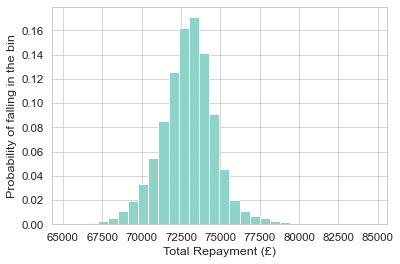

In [40]:
print('Plot...')
#plt.hist(results[:, 2])
S = results[:, 0]
plt.hist(S, weights=np.ones_like(S) / len(S), bins=30)
plt.ylabel("Probability of falling in the bin")
plt.xlabel("Total Repayment (£)")
plt.show() # not necessary, used to hide output of previous command

In [41]:
from recombinator.optimal_block_length import optimal_block_length
b_star = optimal_block_length(np.array(all_data))
print(b_star)

(OptimalBlockLength(b_star_sb=1.3136503103495534, b_star_cb=1.5037542199917384), OptimalBlockLength(b_star_sb=2.708817311568751, b_star_cb=3.1008217570277754), OptimalBlockLength(b_star_sb=30.080122776986162, b_star_cb=34.433144960568946))


100 runs | 1 (s) | 2 (s) | 3 (s)
--- | --- | --- | ---
jit multiprocessing pool (first 5s is setup) | 5.72 | 5.86 | 5.34
jit no pool | 6.78 | 3.08 | 3.02 | 3.03

1000 runs | 1 (s) | 2 (s) | 3 (s)
--- | --- | --- | ---
jit multiprocessing pool no gil (first 5s is setup) | 10.2 | 10.8
jit multiprocessing pool no gil everywhere (first 5s is setup) | 10.4 | 10.1 
jit multiprocessing pool (first 5s is setup) | 10.6 | 9.94 
jit njit parallel | 0.255
jit no pool | 31.1

100000 runs | 1 (s) | 2 (s) | 3 (s)
--- | --- | --- | ---
jit njit parallel | 25 | 25.1
jit njit parallel typed list | 11.3 | 11.8
jit multiprocessing pool | 543.8